# API @Twitter -- Tweepy
<br>
Objectif initial : utiliser les tweets afin d'extraire le ressenti des utilisateurs de Twitter sur les banques aussi bien les banques conventionnelles que les banques en lignes, néo-banques et fintech. 
<br><br>Cette session a pour objectif de vous présenter l'utilisation de l'API Twitter, son fonctionnement et son exploitation, en abordant les étapes suivantes:
<li> Présentation du package tweepy pour récupérer des tweets </li>
<li> Calcul d'indicateurs liés à la présence sur Twitter </li>
<li> Observation des emotes pour catégoriser les tweets positfs/négatifs </li>
<li> Analyse de sentiment via Textblob </li>

Tout le long de l'exercice nous prendrons pour exemple les références suivantes : <b>@Boursorama, @creditdunord, @SG_etvous, @SG_presse et @SocieteGenerale</b>

## 1 - Présentation de l'API twitter

Twitter met à disposition une section développeur qui permet l'utilisation des API. Cependant une demande d'accès est  nécessaire. Parmi les options possibles celles qui nous intéresse est la partie Seach Tweets. Pour cela nous allons utiliser, sous python, le package tweepy.

Lien vers la documentation officiel : https://developer.twitter.com/en/docs

Le code permettant la récupération des tweets est inspiré de l'algorithme réalisé par Alexander Galea (Data Analyst. M.Sc in Physics at the University of Guelph - 2016) : 
https://galeascience.wordpress.com/2016/03/18/collecting-twitter-data-with-python/

In [2]:
import tweepy
from tweepy import OAuthHandler
import json
import datetime as dt
import time
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_colwidth',-1)

In [2]:
def load_api():
    ''' Function that loads the twitter API after authorizing the user. '''

    consumer_key = ''
    consumer_secret = ''
    access_token = ''
    access_secret = ''

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    # load the twitter API via tweepy
    return tweepy.API(auth)

In [4]:
def tweet_search(api, query, max_tweets, max_id, since_id):
    ''' Function that takes in a search string 'query', the maximum
        number of tweets 'max_tweets', and the minimum (i.e., starting)
        tweet id. It returns a list of tweepy.models.Status objects. '''

    searched_tweets = []
    while len(searched_tweets) < max_tweets:
        remaining_tweets = max_tweets - len(searched_tweets)
        try:            
            new_tweets = api.search(q=query, count=remaining_tweets,
                                    since_id=str(since_id),
                                    lang= "fr",
                                    max_id=str(max_id-1),
                                    tweet_mode='extended')
            print('found',len(new_tweets),'tweets')
            if not new_tweets:
                print('no tweets found')
                break
            searched_tweets.extend(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError:
            print('exception raised, waiting 15 minutes')
            print('(until:', dt.datetime.now()+dt.timedelta(minutes=15), ')')
            time.sleep(15*60)
            break # stop the loop
    return searched_tweets, max_id


In [5]:
def get_tweet_id(api, date='', days_ago=9, query='a'):
    ''' Function that gets the ID of a tweet. This ID can then be
        used as a 'starting point' from which to search. The query is
        required and has been set to a commonly used word by default.
        The variable 'days_ago' has been initialized to the maximum
        amount we are able to search back in time (9).'''

    # return an ID from __ days ago
    td = dt.datetime.now() - dt.timedelta(days=days_ago)
    tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
    # get list of up to 10 tweets
    tweet = api.search(q=query, count=10, until=tweet_date, lang= "fr",tweet_mode='extended')
    #print('search limit (start/stop):',tweet[0].created_at)
    # return the id of the first tweet in the list
    return tweet[0].id

In [6]:
def write_tweets(tweets, filename):
    ''' Function that appends tweets to a file. '''

    with open(filename, 'a') as f:
        for tweet in tweets:
            json.dump(tweet._json, f)
            f.write('\n')

In [7]:
def main():
    ''' This is a script that continuously searches for tweets
        that were creXCCated over a given number of days. The search
        dates and search phrase can be changed below. '''

    ''' search variables: '''
    search_phrases = ['@creditdunord', '@SocieteGenerale','@Boursorama,','@SG_etvous','@SG_presse']
    time_limit = 1.5                           # runtime limit in hours
    max_tweets = 100                           # number of tweets per search (will be
                                               # iterated over) - maximum is 100
    min_days_old, max_days_old = 1,3           # search limits e.g., from 7 to 8
                                               # gives current weekday from last week,
                                               # min_days_old=0 will search from right now

    # loop over search items,
    # creating a new file for each
    for search_phrase in search_phrases:

        print('Search phrase =', search_phrase)

        ''' other variables '''
        name = search_phrase.split()[0]
        json_file_root = 'get_tweet' + '/'
        os.makedirs(os.path.dirname(json_file_root), exist_ok=True)
        read_IDs = False
        
        # open a file in which to store the tweets
        if max_days_old - min_days_old == 1:
            d = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}'.format(d.year, d.month, d.day)
        else:
            d1 = dt.datetime.now() - dt.timedelta(days=max_days_old-1)
            d2 = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}_to_{3}-{4:0>2}-{5:0>2}'.format(
                  d1.year, d1.month, d1.day, d2.year, d2.month, d2.day)
        json_file = json_file_root + name + '_' + day + '.json'
        if os.path.isfile(json_file):
            print('Appending tweets to file named: ',json_file)
            read_IDs = True
        
        # authorize and load the twitter API
        api = load_api()
        
        # set the 'starting point' ID for tweet collection
        if read_IDs:
            # open the json file and get the latest tweet ID
            with open(json_file, 'r') as f:
                lines = f.readlines()
                max_id = json.loads(lines[-1])['id']
                print('Searching from the bottom ID in file')
        else:
            # get the ID of a tweet that is min_days_old
            if min_days_old == 0:
                max_id = -1
            else:
                max_id = get_tweet_id(api, days_ago=(min_days_old-1))
        # set the smallest ID to search for
        since_id = get_tweet_id(api, days_ago=(max_days_old-1))
        print('max id (starting point) =', max_id)
        print('since id (ending point) =', since_id)

        ''' tweet gathering loop  '''
        start = dt.datetime.now()
        end = start + dt.timedelta(hours=time_limit)
        count, exitcount = 0, 0
        while dt.datetime.now() < end:
            count += 1
            print('count =',count)
            # collect tweets and update max_id
            tweets, max_id = tweet_search(api, search_phrase, max_tweets,
                                          max_id=max_id, since_id=since_id)
            # write tweets to file in JSON format
            if tweets:
                write_tweets(tweets, json_file)
                exitcount = 0
            else:
                exitcount += 1
                if exitcount == 1:
                    if search_phrase == search_phrases[-1]:
                        sys.exit('Maximum number of empty tweet strings reached - exiting')
                    else:
                        print('Maximum number of empty tweet strings reached - breaking')
                        break
                    
                    
if __name__ == "__main__":
    main()

Search phrase = @creditdunord
max id (starting point) = 1194766893552472064
since id (ending point) = 1194042118446231552
count = 1
found 27 tweets
found 0 tweets
no tweets found
count = 2
found 0 tweets
no tweets found
Maximum number of empty tweet strings reached - breaking
Search phrase = @SocieteGenerale
max id (starting point) = 1194766893552472064
since id (ending point) = 1194042118446231552
count = 1
found 100 tweets
count = 2
found 100 tweets
count = 3
found 100 tweets
count = 4
found 100 tweets
count = 5
found 100 tweets
count = 6
found 100 tweets
count = 7
found 100 tweets
count = 8
found 100 tweets
count = 9
found 100 tweets
count = 10
found 100 tweets
count = 11
found 100 tweets
count = 12
found 100 tweets
count = 13
found 66 tweets
found 0 tweets
no tweets found
count = 14
found 0 tweets
no tweets found
Maximum number of empty tweet strings reached - breaking
Search phrase = @Boursorama,
max id (starting point) = 1194766893552472064
since id (ending point) = 1194042118446

SystemExit: Maximum number of empty tweet strings reached - exiting

C:\Users\Samy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



#### Lecture des JSON

Le package tweepy nous permet de récupérer les tweets que l'on savegarde au format "json" (format de structuration de données) qui a l'avantage d'être léger en espace de stockage. La fonction suivante nous permet de créer un dataframe à partir de ces fichiers.
Lecture des json sur l'ensemble des fichiers que nous avons récupéré précédemment. On ajoute une colonne name_request qui fait référence au terme recherché.

In [3]:
#Lecture des json 
df_all = pd.DataFrame() 
Dossier_tweet = [x for x in os.listdir("get_tweet")]
for file_json in Dossier_tweet:
    tweets = []
    file = "get_tweet/" + file_json 
    nom_requete = file_json [:-30]
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))
    df = pd.DataFrame(tweets) 
    df['name_request'] = nom_requete
    frames = [df_all, df]
    df_all = pd.concat(frames)  
    
print(list(df_all))
df_all.head(4)#[['full_text',"metadata"]]

['contributors', 'coordinates', 'created_at', 'display_text_range', 'entities', 'extended_entities', 'favorite_count', 'favorited', 'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata', 'name_request', 'place', 'possibly_sensitive', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated', 'user']


contributors coordinates                      created_at display_text_range  \
0  None         None        Wed Nov 13 23:35:50 +0000 2019  [23, 119]           
1  None         None        Wed Nov 13 23:35:20 +0000 2019  [0, 140]            
2  None         None        Wed Nov 13 22:05:09 +0000 2019  [0, 274]            
3  None         None        Wed Nov 13 20:44:36 +0000 2019  [91, 150]           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     entities  \
0  {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'MASSIFUND', 'name': 'MASSIFUND', 'id': 2855938835, 'id_str': '2855938835', 'indices': [0, 10]}, {'screen_name': 'Boursorama', 'name': 'Boursorama', 'id': 33459117, 'id_str': '33459117', 'indices': [11, 22]}], 'urls': []}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1  {'hashtags': [{'text': 'ExpertEH', 'indices': [120, 129]}], 'symbols': [], 'user_mentions': [{'screen_name': 'eulerhermesFR', 'name': 'Euler Hermes France', 'id': 819185887091322880, 'id_str': '819185887091322880', 'indices': [3, 17]}], 'urls': []}                                                                                                                                                                                                                                                                                                                                               

## 2 - Indicateurs sur les tweets observés sur l'année 2019


Historique étudié : 14 juillet au 02 novembre 2019

In [4]:
#Lecture des json 
df_all = pd.DataFrame() 
Dossier_tweet = [x for x in os.listdir("sure")]
for file_json in Dossier_tweet:
    tweets = []
    file = "sure/" + file_json 
    nom_requete = file_json [:-30]
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))
    df = pd.DataFrame(tweets) 
    df['user_link'] = list(map(lambda tweet: tweet['user']['entities']['description']['urls']
                                  if tweet['user'] != None else '', tweets))
    df['user_link'] = df['user_link'].apply(lambda x: str(x))
    df = df[['id_str','created_at','full_text','in_reply_to_status_id_str','retweet_count','user_link']]
    df['name_request'] = nom_requete
    df['begin_by_RT'] = df.full_text.map(lambda x: 1 if x.startswith('RT ') == True else 0)
    df['Tweet_natif_bq'] = df.full_text.map(lambda x: 1 if x.startswith('RT ' + nom_requete) == True else 0)
    frames = [df_all, df]
    df_all = pd.concat(frames)  
    
df_all = df_all.drop_duplicates(subset=['created_at','full_text','name_request'])

In [8]:
df_all[(df_all.Tweet_natif_bq == True) & (df_all.name_request == "@creditdunord")]
df_all[df_all.id_str == "1181860058600222720"][['created_at','full_text','name_request','id_str','begin_by_RT','user_link','Tweet_natif_bq']]
df_all[(df_all.Tweet_natif_bq == False) & (df_all.begin_by_RT == False) & (df_all.name_request == "@creditdunord")]

df_all[df_all.id_str.isin(['1189134241642242048','1188182032880410624','1189057169100070912'])][['created_at','full_text','name_request','id_str','begin_by_RT','user_link','Tweet_natif_bq']]


,created_at,full_text,name_request,id_str,begin_by_RT,user_link,Tweet_natif_bq
39,Tue Oct 29 10:57:50 +0000 2019,"RT @creditdunord: #SamsungPay, le paiement mobile simple et sécurisé, disponible pour les clients du groupe @creditdunord https://t.co/kTEp…",@creditdunord,1189134241642242048,1,[],1
44,Tue Oct 29 05:51:35 +0000 2019,Hier @mamatdunet a animé les premiers ateliers de la #data #ia #school du @LeChaudron_io lors de convention de la Direction Data Architecture et Projet @creditdunord . Cette nouvelle potion numérique du Chaudron est particulièrement savoureuse et puissante à terme. Prometteur !,@creditdunord,1189057169100070912,0,[],0
1216,Sat Oct 26 19:54:06 +0000 2019,"Bonjour @SocieteGenerale, pourquoi après avoir changé une adresse de Paris en Versailles ma nouvelle CB arrive à Pau ?",@SocieteGenerale,1188182032880410624,0,[],0


In [6]:
df_all[df_all.full_text.str.contains("Hier @mamatdunet")]

,id_str,created_at,full_text,in_reply_to_status_id_str,retweet_count,user_link,name_request,begin_by_RT,Tweet_natif_bq
37,1189149386821046272,Tue Oct 29 11:58:01 +0000 2019,RT @emmaroux: Hier @mamatdunet a animé les premiers ateliers de la #data #ia #school du @LeChaudron_io lors de convention de la Direction…,None,4,[],@creditdunord,1,0
38,1189149222798614529,Tue Oct 29 11:57:22 +0000 2019,RT @emmaroux: Hier @mamatdunet a animé les premiers ateliers de la #data #ia #school du @LeChaudron_io lors de convention de la Direction…,None,4,[],@creditdunord,1,0
42,1189092061053632513,Tue Oct 29 08:10:14 +0000 2019,RT @emmaroux: Hier @mamatdunet a animé les premiers ateliers de la #data #ia #school du @LeChaudron_io lors de convention de la Direction…,None,4,"[{'url': 'https://t.co/9mDhTwHOdY', 'expanded_url': 'http://LeChaudron.io', 'display_url': 'LeChaudron.io', 'indices': [0, 23]}]",@creditdunord,1,0
43,1189058869638684674,Tue Oct 29 05:58:20 +0000 2019,RT @emmaroux: Hier @mamatdunet a animé les premiers ateliers de la #data #ia #school du @LeChaudron_io lors de convention de la Direction…,None,4,[],@creditdunord,1,0
44,1189057169100070912,Tue Oct 29 05:51:35 +0000 2019,Hier @mamatdunet a animé les premiers ateliers de la #data #ia #school du @LeChaudron_io lors de convention de la Direction Data Architecture et Projet @creditdunord . Cette nouvelle potion numérique du Chaudron est particulièrement savoureuse et puissante à terme. Prometteur !,None,4,[],@creditdunord,0,0


In [4]:
df_all.head(5)

,id_str,created_at,full_text,in_reply_to_status_id_str,retweet_count,user_link,name_request,begin_by_RT,Tweet_natif_bq
0,1150426691715551237,Sun Jul 14 15:27:51 +0000 2019,"@haikdjaiv dans les conditions de @boursorama c'est pourtant écrit: ""Incentive : non autorisé""",1150423418145312769,0,[],@Boursorama,0,0
1,1150176910745493504,Sat Jul 13 22:55:19 +0000 2019,@yonitonparrain @Boursorama @Hellobank_fr OK merci pour ton retour.,1150159237747740677,0,[],@Boursorama,0,0
2,1150159237747740677,Sat Jul 13 21:45:05 +0000 2019,"@Theudric1 @Boursorama @Hellobank_fr Boursorama j'me rappel plus bien mais en moins de 30 jours c'est plié si tu envois tout rapidement (justificatifs, dépot), et record toute catégorie OrangeBank 6 jours 😮 je sais pas si j'ai eu de la chance mais c'est le temps que ça a mis pour moi.",1150076492614946818,0,"[{'url': 'https://t.co/JUmOMCP5qt', 'expanded_url': 'http://bour.so/1KcZHrYmFW', 'display_url': 'bour.so/1KcZHrYmFW', 'indices': [97, 120]}]",@Boursorama,0,0
3,1150081593266057216,Sat Jul 13 16:36:33 +0000 2019,"@nclas93 @Boursorama @Hellobank_fr C'est pareil chez @Hellobank_fr , tu ouvres en ligne et tu envoie les documents. \n\nCela fait plus de 15 jours qu'ils ont tout, ça fait un mois que j'ai commencé les démarches !\nJ'en ai déjà un.....sinon ça aurait été avec plaisir",1150079810158436355,0,[],@Boursorama,0,0
4,1150079810158436355,Sat Jul 13 16:29:28 +0000 2019,"@Theudric1 @Boursorama @Hellobank_fr Je ne sais plus exactement, mais si tu remplis le dossier correctement c'est assez rapide. L'avantage c'est que chez boursorama, c'est 100% en ligne, rien à renvoyer par courrier (je ne sais pas si c'est pareil chez Hello). Si t'as besoin d'un parrainage, n'hésite pas ... 😉",1150076492614946818,0,[],@Boursorama,0,0


### Indicateur 1 : Tweets natifs réalisés par la banque (qui sont RT).
Un tweet commancant par RT + name_request est un tweet réalisé par la banque, on en déduit le nombre de tweets initiés par la banque qui ont été RT.

,name_request,Frequence_Ind1,Pourcentage_Ind1
0,@Boursorama,967,0.689729
3,@SocieteGenerale,216,0.154066
4,@creditdunord,91,0.064907
1,@SG_etvous,84,0.059914
2,@SG_presse,44,0.031384


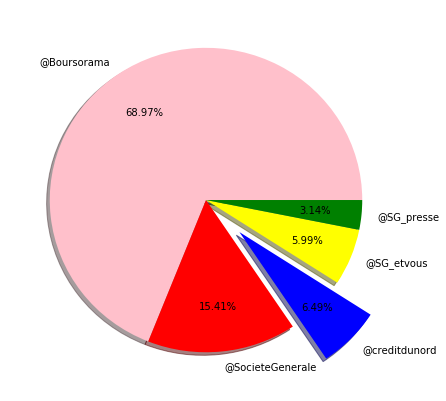

In [26]:
pd_ind1 = df_all[df_all['Tweet_natif_bq']==1]
pd_ind1 = pd_ind1.drop_duplicates(subset=['full_text','name_request'])

Freq_ind1 = pd.DataFrame()
Freq_ind1 = pd_ind1.groupby(['name_request']).size().reset_index(name='Frequence_Ind1')
Freq_ind1['Pourcentage_Ind1'] = Freq_ind1['Frequence_Ind1'] / Freq_ind1['Frequence_Ind1'].sum() 
Freq_ind1 = Freq_ind1.sort_values('Frequence_Ind1', ascending = False )

plt.figure(figsize=(7,7));
x = Freq_ind1['Frequence_Ind1']
labels = Freq_ind1['name_request']
plt.pie(x,labels = labels,
           colors = [ 'pink', 'red', 'blue', 'yellow', 'green'],
           explode = [0, 0, 0.3, 0, 0],
           autopct = lambda x: str(round(x, 2)) + '%',
           pctdistance = 0.7, 
            labeldistance = 1.1,
           shadow = True
       );

Freq_ind1

In [27]:
#Exemple:
Exemple_cdn = df_all[(df_all['Tweet_natif_bq']==1) & (df_all['name_request'] == '@creditdunord')].\
              drop_duplicates(subset=['full_text','name_request'])[['name_request','full_text']]
Exemple_cdn.head(5)

,name_request,full_text
2,@creditdunord,"RT @creditdunord: #Mecenat @creditdunord aux côtés d' @ImagineforMargo depuis 2011, pour faire avancer la recherche et mieux soigner les ca…"
9,@creditdunord,RT @creditdunord: Faire grandir une idée ! Suivez-nous sur Twitter https://t.co/7VRUnX9kh3
13,@creditdunord,"RT @creditdunord: Pourquoi #entreprendre en #franchise ? L’énergie de 3 franchiseurs tête de réseau. Témoignage @Daniel_Moquet, Patricia Ga…"
16,@creditdunord,"RT @creditdunord: En ce moment, matinale de l'#innovation : La voix du client au sein du groupe @creditdunord. Une expérimentation Banque R…"
23,@creditdunord,RT @creditdunord: .@creditdunord lance une offre @SwissLife_fr par l’intermédiaire d’@Aon France pour les #ProfLib médicales. Un parcours f…


### Indicateur 2 : Tweets natifs réalisés par les utilisateurs
En filtrant sur la variable in_reply_to_status_id_str on en déduit les tweets natifs réalisés par les utilisateurs

,name_request,Frequence_Ind2,Pourcentage_Ind2
3,@SocieteGenerale,2105,0.473992
0,@Boursorama,1614,0.363432
1,@SG_etvous,457,0.102905
4,@creditdunord,239,0.053817
2,@SG_presse,26,0.005855


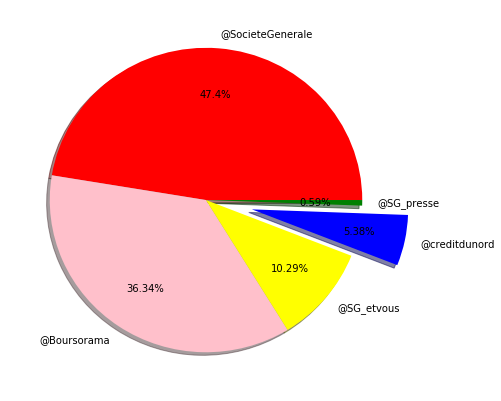

In [30]:
pd_ind2 = df_all[df_all['begin_by_RT']==0]
pd_ind2 = pd_ind2[pd_ind2['in_reply_to_status_id_str'].isnull()]

Freq_ind2 = pd.DataFrame()
Freq_ind2 = pd_ind2.groupby(['name_request']).size().reset_index(name='Frequence_Ind2')
Freq_ind2['Pourcentage_Ind2'] = Freq_ind2['Frequence_Ind2'] / Freq_ind2['Frequence_Ind2'].sum() 
Freq_ind2 = Freq_ind2.sort_values('Frequence_Ind2', ascending = False )

plt.figure(figsize=(7,7));
x = Freq_ind2['Frequence_Ind2']
labels = Freq_ind2['name_request']
plt.pie(x,labels = labels,
           colors = [ 'red', 'pink', 'yellow', 'blue', 'green'],
           explode = [0, 0, 0, 0.3, 0],
           autopct = lambda x: str(round(x, 2)) + '%',
           pctdistance = 0.7, 
            labeldistance = 1.1,
           shadow = True
       );
Freq_ind2

In [31]:
pd_ind2 = df_all[df_all['begin_by_RT']==0]
pd_ind2 = pd_ind2[pd_ind2['in_reply_to_status_id_str'].isnull()]
pd_ind2

,id_str,created_at,full_text,in_reply_to_status_id_str,retweet_count,user_link,name_request,begin_by_RT,Tweet_natif_bq
5,1150076492614946818,Sat Jul 13 16:16:17 +0000 2019,"@Boursorama Bonjour, combien de temps faut il pour ouvrir un compte chez vous et qu'il soit actif ?\nJe suis en cours pour @Hellobank_fr , je crois que je vais tout envoyer promener !\nCela fait plus d'un mois et toujours rien !!",None,0,[],@Boursorama,0,0
6,1150056700495519744,Sat Jul 13 14:57:39 +0000 2019,"Pour toute ouverture d'un compte avec CB chez @boursorama banque, profitez d'une prime de 80€ en utilisant le lien ci-dessous :\nhttps://t.co/F7x9sdc7OM",None,0,[],@Boursorama,0,0
9,1149981806692839425,Sat Jul 13 10:00:03 +0000 2019,"Vidéo - ""La taxation de l'économie numérique est un vrai sujet"" @Boursorama https://t.co/vwHUzV4GgK https://t.co/cklzZBJG4a",None,0,[],@Boursorama,0,0
17,1149906228358930432,Sat Jul 13 04:59:43 +0000 2019,"@Boursorama on ne peut pas demander à être rappelé, le site affiche un message d'erreur",None,0,[],@Boursorama,0,0
18,1149791566355206144,Fri Jul 12 21:24:06 +0000 2019,"[Blog] Comment je gère mes finances personnelles avec @Boursorama, @Hellobank_fr et @aumaxpourmoi ? https://t.co/KqnGXRSfuD",None,0,[],@Boursorama,0,0
21,1149766135849598977,Fri Jul 12 19:43:03 +0000 2019,@Boursorama je suis proprement scandalisé par la fermeture de mes comptes de votre fait et par l’amateurisme de vos équipes. Je déconseille à quiconque d’ouvrir un compte la bas. #banque #amateurisme #boursorama @60millions,None,0,[],@Boursorama,0,0
30,1149705628740288512,Fri Jul 12 15:42:37 +0000 2019,"Que c'est compliqué d'ouvrir un compte chez @Boursorama ! Etre obligé de ré-envoyer tout un dossier complet par la poste pour joindre une autre pièce qui n'a pas été acceptée, c'est n'importe quoi. Revenir en France n'est vraiment pas simple.",None,0,[],@Boursorama,0,0
32,1149697182485925888,Fri Jul 12 15:09:03 +0000 2019,@Boursorama votre adresse email commercial@boursorama.fr ne marche pas. Le mail est revenu chez moi,None,0,[],@Boursorama,0,0
33,1149696867275554823,Fri Jul 12 15:07:48 +0000 2019,@Boursorama je viens de vous envoyer ma rétractation par courrier en recommandé avec avis de réception,None,0,[],@Boursorama,0,0
34,1149693158357385217,Fri Jul 12 14:53:03 +0000 2019,L'#Europe n'est pas la seule à adopter la tendance des taux bas ! 👇\nhttps://t.co/CEcAEkkZPM par @boursorama,None,1,[],@Boursorama,0,0


In [31]:
Exemple_cdn = pd_ind2[pd_ind2['name_request'] == '@creditdunord']
Exemple_cdn.head(5)

,id_str,created_at,full_text,in_reply_to_status_id_str,retweet_count,user_link,name_request,begin_by_RT,Tweet_natif_bq
0,1150503274266746882,Sun Jul 14 20:32:10 +0000 2019,Bonjour @creditdunord cela fait deux ans que je cherche à fermer un compte qui n'a jamais fonctionné car vous ne m'avez jamais adressé l'offre de prêt pour laquelle le compte a été ouvert. J'ai fait tous les courriers. Je dois faire quoi pour que vous fassiez votre job ?,None,0,[],@creditdunord,0,0
1,1150317226689486849,Sun Jul 14 08:12:53 +0000 2019,"@creditdunord Bonjour, #GooglePay sera-t-il bientôt disponible au Crédit du Nord ?",None,0,[],@creditdunord,0,0
7,1149735847161454592,Fri Jul 12 17:42:41 +0000 2019,Merci aux #teamNEXT réunies pour fêter un premier semestre très intense et célébrer cette belle cohésion d’équipes #agiles @creditdunord et #itim. Fière d’avoir partagé avec vous ce moment 👍 https://t.co/wm90sN6coi,None,0,[],@creditdunord,0,0
12,1149589619651964928,Fri Jul 12 08:01:38 +0000 2019,"#Mecenat @creditdunord aux côtés d' @ImagineforMargo depuis 2011, pour faire avancer la recherche et mieux soigner les cancers des enfants. Margo, grande combattante à l'origine de cette belle mobilisation. Rejoignez-nous pour la #CourseEnfantsSansCancer https://t.co/lrasCANkkF https://t.co/MElAj0Hm00",None,8,[],@creditdunord,0,0
14,1149242423962480640,Thu Jul 11 09:02:00 +0000 2019,"@creditdunord , un dossier de délégation d’assurance de prêt immo non traité depuis 2 mois, une conseillère qui promets de nous rappeler 4 fois, sans nouvelles, 6 mails sans réponse. Quel suivi clientèle... #creditdunord #banquecourtois #serviceclient #lillerihour @banquecourtois",None,0,[],@creditdunord,0,0


### Indicateur 3 : Qui sont les + RT ?

,name_request,nb_retweet_tot,Pourcentage_Ind3
3,@SocieteGenerale,7757,0.523061
0,@Boursorama,3136,0.211463
1,@SG_etvous,3012,0.203102
4,@creditdunord,619,0.041740
2,@SG_presse,306,0.020634


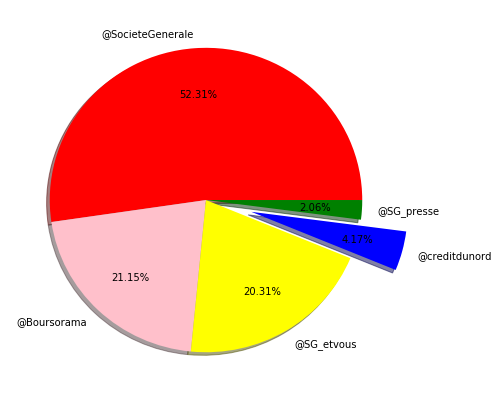

In [32]:
pd_ind3 = df_all[df_all['begin_by_RT']==1]
pd_ind3 = pd_ind3.drop_duplicates(subset=['full_text','name_request'])
pd_ind3 = pd_ind3.sort_values('retweet_count', ascending = False )

Freq_ind3 = pd.DataFrame()
Freq_ind3 = pd_ind3.groupby(['name_request'])['retweet_count'].sum().reset_index(name='nb_retweet_tot')
Freq_ind3['Pourcentage_Ind3'] = Freq_ind3['nb_retweet_tot'] / Freq_ind3['nb_retweet_tot'].sum() 
Freq_ind3 = Freq_ind3.sort_values('nb_retweet_tot', ascending = False )

plt.figure(figsize=(7,7));
x = Freq_ind3['Pourcentage_Ind3']
labels = Freq_ind3['name_request']
plt.pie(x,labels = labels,
           colors = [ 'red', 'pink', 'yellow', 'blue', 'green'],
           explode = [0, 0, 0, 0.3, 0],
           autopct = lambda x: str(round(x, 2)) + '%',
           pctdistance = 0.7, 
            labeldistance = 1.1,
           shadow = True
       );

Freq_ind3

In [33]:
Exemple_cdn = pd_ind3[pd_ind3['name_request'] == '@creditdunord'][['name_request','full_text']]
Exemple_cdn.head(5)

,name_request,full_text
66,@creditdunord,RT @creditdunord: #Cybersécurité Le risque cyber est devenu le 2e plus redouté par les entreprises. Les solutions matérielles et logicielle…
67,@creditdunord,RT @creditdunord: #Cybersécurité : tout savoir sur la fraude par ingénierie sociale et adopter les bons réflexes afin de s'en protéger effi…
9,@creditdunord,RT @creditdunord: Faire grandir une idée ! Suivez-nous sur Twitter https://t.co/7VRUnX9kh3
3,@creditdunord,RT @quentinperinel: 💡 La banque est une vieille dame de l'industrie... à la pointe de la technologie et de la transformation ! 💡 C'est le p…
13,@creditdunord,RT @creditdunord: Nos experts mettent leur énergie au service de votre envie d’entreprendre. Suivez-nous sur Twitter https://t.co/Rtl9RlJel2


### Indicateur 4 : Nombres de tweets natifs des utilisateurs + reply ?

,name_request,Frequence_Ind4,Pourcentage_Ind4
3,@SocieteGenerale,4132,0.419280
0,@Boursorama,3087,0.313242
1,@SG_etvous,2231,0.226383
4,@creditdunord,370,0.037544
2,@SG_presse,35,0.003551


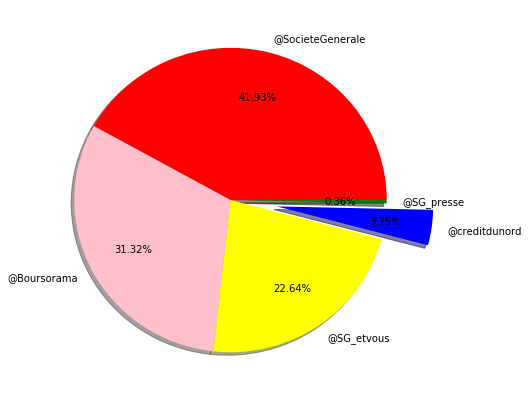

In [34]:
pd_ind4 = df_all[df_all['begin_by_RT']==0]
pd_ind4 = pd_ind4.drop_duplicates(subset=['full_text','name_request'])
pd_ind4 = pd_ind4.sort_values('retweet_count', ascending = False )

Freq_ind4 = pd.DataFrame()
Freq_ind4 = pd_ind4.groupby(['name_request']).size().reset_index(name='Frequence_Ind4')
Freq_ind4['Pourcentage_Ind4'] = Freq_ind4['Frequence_Ind4'] / Freq_ind4['Frequence_Ind4'].sum() 
Freq_ind4 = Freq_ind4.sort_values('Frequence_Ind4', ascending = False )


plt.figure(figsize=(7,7));
x = Freq_ind4['Pourcentage_Ind4']
labels = Freq_ind4['name_request']
plt.pie(x,labels = labels,
           colors = [ 'red', 'pink', 'yellow', 'blue', 'green'],
           explode = [0, 0, 0, 0.3, 0],
           autopct = lambda x: str(round(x, 2)) + '%',
           pctdistance = 0.7, 
            labeldistance = 1.1,
           shadow = True
       );

Freq_ind4

In [15]:
Exemple_cdn = pd_ind4[pd_ind4['name_request'] == '@creditdunord'][['name_request','full_text']]
Exemple_cdn.head(5)

,name_request,full_text
28,@creditdunord,"💡 La banque est une vieille dame de l'industrie... à la pointe de la technologie et de la transformation ! 💡 C'est le propos de mon invitée le #TalkDécideurs du @Le_Figaro, @FMDelasalles, DG du @creditdunord, dont la première agence date de... 1760 🤪 https://t.co/xP7rhJQgKN"
12,@creditdunord,"#Mecenat @creditdunord aux côtés d' @ImagineforMargo depuis 2011, pour faire avancer la recherche et mieux soigner les cancers des enfants. Margo, grande combattante à l'origine de cette belle mobilisation. Rejoignez-nous pour la #CourseEnfantsSansCancer https://t.co/lrasCANkkF https://t.co/MElAj0Hm00"
53,@creditdunord,Vous n'utilisez pas encore #SamsungPay ? Il y a un début à tout puisque @creditdunord est désormais disponible dans votre application. https://t.co/WjM5RmbVeE https://t.co/flnLCXhrKE
140,@creditdunord,"J-5 avant la 8e édition de la course. Depuis 2011, le Groupe @creditdunord est mécène de l’association @ImagineforMargo Un engagement né de l’émotion. https://t.co/lrasCB4VJf https://t.co/ocDMUZM6Qs"
31,@creditdunord,"""Le financement de l’économie au cœur des territoires, cette mission qui est notre raison d’être est formidable."" #Innovation #TransfoNum #Portrait @FMDelasalles directrice générale du groupe @creditdunord @latribune @DelphineCuny https://t.co/brEDKwzYfW"


## 3 - Observation des emotes pour catégoriser les tweets positfs/négatifs 


À partir d'une liste de 79 emotes, nous avons affecté pour chacun d'eux le sentiment associés entre positif, neutre ou négatif.
En observant leur présence dans les tweets, on en catégorise le sentiment du tweet. 

In [4]:
#Etude d'appréciation des tweets via les emotes 
emotes =  ['😀','😁','😂','🤣','😃','😄','😅','😆','😉','😊','😋','😎','😍','😘','😗','😙','😚','🙂','🤗','🤩','🤔','🤨','😐','😑','😶','🙄','😏','😣','😥','😮','🤐','😯','😪','😫','😴','😌','😛','😜','😝','🤤','😒','😓','😔','😕','🙃','🤑','😲','🙁','😖','😞','😟','😤','😢','😭','😦','😧','😨','😩','🤯','😬','😰','😱','😳','🤪','😵','😡','😠','🤬','😷','🤒','🤕','🤢','🤮','🤧','😇','🤠','🤥','🤫','🤭','🧐','🤓']
pattern = '|'.join(emotes)

df_with_emote = df_all[df_all['full_text'].str.contains(pattern)][['full_text','name_request']]
 
Res=pd.DataFrame()
for j in emotes :
    temp  = df_with_emote[df_with_emote['full_text'].str.contains(j)]
    temp = temp.groupby(['name_request']).size().reset_index(name='effectif')
    temp['emote'] = j
    frames = [Res, temp]
    Res = pd.concat(frames) 

#Emotes à definir
only = Res[['emote']].drop_duplicates('emote')

Freq_emotes = pd.DataFrame()
Freq_emotes = Res.groupby(['emote']).size().reset_index(name='nb_occcurence')

#Affectation des catégories
categorie = pd.read_excel('emote_coresp.xlsx') 
Res = Res.merge(categorie, on='emote', how='left')
Freq_final = Res.groupby(['name_request','Categorisation']).sum().reset_index()

Freq_final

,name_request,Categorisation,effectif
0,@Boursorama,1.0,314
1,@Boursorama,2.0,73
2,@Boursorama,3.0,62
3,@SG_etvous,1.0,229
4,@SG_etvous,2.0,53
5,@SG_etvous,3.0,119
6,@SG_presse,1.0,17
7,@SocieteGenerale,1.0,316
8,@SocieteGenerale,2.0,101
9,@SocieteGenerale,3.0,97


In [40]:
df_all[(df_all['name_request']=='@creditdunord') & (df_all['full_text'].str.contains('😡'))] 

,id_str,created_at,full_text,in_reply_to_status_id_str,retweet_count,user_link,name_request,begin_by_RT,Tweet_natif_bq
9,1160845937465614337,Mon Aug 12 09:30:13 +0000 2019,@creditdunord @davidguilbert59 La direction des relations client est sur messagerie. Personne ne répond. Vos conseillers changent environ tous les 2 ans pour éviter trop de proximité avec le client. Vous n’avez rien compris. La relation client est primordiale. La majorité des gens n’ont plus confiance 😡,1150666684182781953,0,[],@creditdunord,0,0
67,1171188410687639559,Mon Sep 09 22:27:31 +0000 2019,"@creditdunord Dites moi, j'avais assez d'argent pour mon prélèvement Bouygues et vous arrivez de nul part avec votre commission d'intervention😡\nJe vais m'en retapé une autre dans 2 mois sans être prévenu une nouvelle fois ou ça n'engage pas une autre commiss pour ce découvert? https://t.co/r1VnKLvARK",None,0,[],@creditdunord,0,0
19,1180758514337234944,Sun Oct 06 08:15:41 +0000 2019,"@dcaizergues @Fanou_SdM @an_conda @Entheosias Malgré mes appels et autres relances, rien n'y fait. #Antarius @creditdunord continue de me réclamer l'attestation des impôts - ce que j'ai transmis. Mais mon frère n'ayant pas payé sa part des droits de succession, ils attendent encore. Alors qu'il n'est pas concerné !😡",1180752648334651394,2,[],@creditdunord,0,0
25,1180406163709583360,Sat Oct 05 08:55:34 +0000 2019,"@creditdunord @creditdunord RÉCLAMATION CLIENT ! 😡 je fais une remise Bcaire MARDI, SAMEDI toujours rien sur mon compte !?\nJ’envoie un mail à la directrice : elle me donne l’adresse mail de son successeur. J’envoie un mail à son successeur mais le mail est erroné. #NoComment",1086292836516093952,0,[],@creditdunord,0,0
26,1180405058955091968,Sat Oct 05 08:51:11 +0000 2019,"@creditdunord RÉCLAMATION CLIENT ! 😡 je fais une remise Bcaire MARDI, SAMEDI toujours rien sur mon compte !?\nJ’envoie un mail à la directrice : elle me donne l’adresse mail de son successeur. J’envoie un mail à son successeur mais le mail est erroné. #NoComment https://t.co/wIwHn7VmGK",None,0,[],@creditdunord,0,0


In [39]:
df_all[(df_all['name_request']=='@creditdunord') & (df_all['full_text'].str.contains('😊'))] 

,id_str,created_at,full_text,in_reply_to_status_id_str,retweet_count,user_link,name_request,begin_by_RT,Tweet_natif_bq
4,1152489987318931458,Sat Jul 20 08:06:39 +0000 2019,"@creditdunord Sur le tag #securité, générer une e-Carte depuis notre espace perso, bientôt disponible également ?\nPar ailleurs, si la réponse à la question sur google pay que vous aviez remontée en mon nom pouvait redescendre, ça serait top !\n😊",1152212797754871810,0,[],@creditdunord,0,0
1,1170009899130130434,Fri Sep 06 16:24:32 +0000 2019,RT @MireilleGerma: Fière d’y participer depuis 8 ans 😊🏃‍♀️! #engagés @imagineformargo @creditdunord #coursesolidaire https://t.co/beT1URQzeq,None,1,[],@creditdunord,1,0
2,1170009157010956290,Fri Sep 06 16:21:35 +0000 2019,Fière d’y participer depuis 8 ans 😊🏃‍♀️! #engagés @imagineformargo @creditdunord #coursesolidaire https://t.co/beT1URQzeq,None,1,[],@creditdunord,0,0


## 4 - Analyse de sentiment avec textblob

Textblob est un package permettant de faire du text mining. Il est possible de faire de la classification supervisée ou non supervisée.
Il est également possible de réaliser une analyse de sentiment rapidement. Le package permet d'obtenir une approximation du sentiment gràce à deux vecteurs :

<li>polarity : valeur pouvant aller de -1 à 1 (du + négatif au + positif) ;
<li>subjectivity : valeur pouvant aller de 0 à 1 (du + objectif au + subjectif).

In [41]:
import re
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

def clean_tweet(tweet):
        '''
        Cleans tweet text by removing links,
        special characters - using regex statements.
        '''
        # In case you forget: you removed the (@[A-Za-z0-9]+)| reg ex.
        # useful site: http://regexr.com/
        if not tweet.endswith((u"à", u"è", u"é", u"ê", u"ï", u"û", u"ç")):
                    tweet = tweet.replace(u"à", "a")
                    tweet = tweet.replace(u"é", "e")
                    tweet = tweet.replace(u"è", "e")
                    tweet = tweet.replace(u"ê", "e")
                    tweet = tweet.replace(u"ï", "i")
                    tweet = tweet.replace(u"î", "i")
                    tweet = tweet.replace(u"ç", "c")
                    
        tweet = re.sub(r'(\s)@\w+',r'\1',tweet)
        tweet = re.sub(r'(\s)#\w+',r'\1',tweet)
                    
        return ' '.join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    
    # create TextBlob object of passed tweet text 
    analysis = tb(clean_tweet(tweet)) 
    
    # set sentiment from pattern analyzer
    if (analysis.sentiment[0] > 0.1 and analysis.sentiment[1] < 0.5): 
        return 'positive'
    elif (analysis.sentiment[0] < -0.1 and analysis.sentiment[1] < 0.5): 
        return 'negative'
    else: 
        return 'neutral'
    
def get_result(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    
    # create TextBlob object of passed tweet text 
    analysis = tb(clean_tweet(tweet)) 

    return analysis.sentiment

In [5]:
#exemple text_blob
import re
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
print("test de très content:", tb("très content").sentiment)
print("pas content:", tb("pas content").sentiment)


test de très content: (1.0, 1.0)
pas content: (-0.325, 0.6)


In [64]:
df_all['sentiment'] = df_all.apply(lambda row: get_tweet_sentiment(row['full_text']), axis=1)
df_all['score'] = df_all.apply(lambda row: get_result(row['full_text']), axis=1)

df_natif = df_all.loc[df_all['begin_by_RT']==0]
df_g = pd.crosstab(df_natif['name_request'], df_natif['sentiment'], values=None, rownames=None, colnames=None, aggfunc=None, margins=True, dropna=True, normalize='index')
df_g['ratio_fp'] = df_g['negative'] / df_g['positive'] * 100
df_g.sort_values('ratio_fp', ascending = False )


sentiment,negative,neutral,positive,ratio_fp
name_request,,,,
@Boursorama,0.067808,0.636422,0.295770,22.925764
@SG_etvous,0.052186,0.700714,0.247101,21.119134
All,0.052950,0.626929,0.320121,16.540643
@SocieteGenerale,0.045084,0.585372,0.369544,12.199870
@creditdunord,0.026954,0.579515,0.393531,6.849315
@SG_presse,0.000000,0.514286,0.485714,0.000000


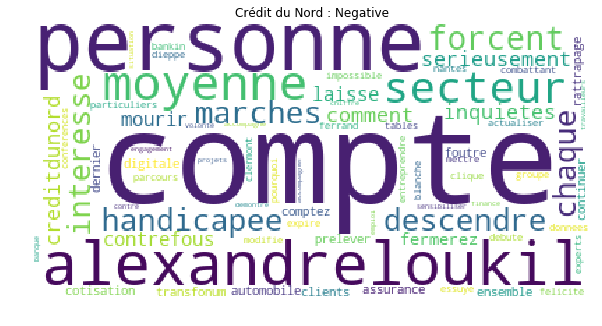

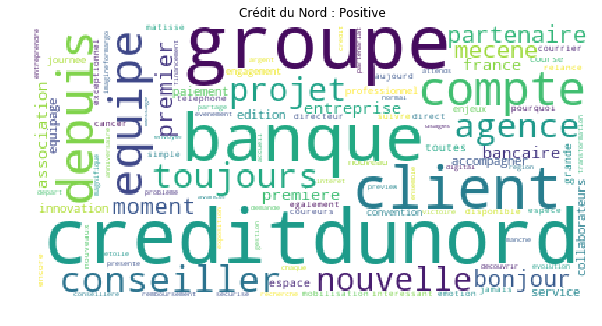

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import Image as im
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline 

def wc_app(name,sence,title):    
    tweet_cleaned = []

    df_natif = df_all.loc[df_all['begin_by_RT']==0]
    negative_df = df_natif.loc[df_natif['sentiment']==sence,['full_text','name_request']]
    negative_df = negative_df.loc[negative_df['name_request']==name,['full_text']]

    for tweet in negative_df['full_text']:
        tweet_cleaned.append(clean_tweet(tweet))

    raw_string = ' '.join(tweet_cleaned)

    words = raw_string.split(" ")
    words = [w for w in words if len(w) > 5]
    words = [w.lower() for w in words]
    words = [w for w in words if w not in STOPWORDS]
        
    wc = WordCloud(background_color="white", mode="RGBA", max_words=100,random_state=42)

    clean_string = ','.join(words)
    wc.generate(clean_string)
    plt.figure(figsize=[10,10])
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    
wc_app(name = "@creditdunord", sence = "negative", title ="Crédit du Nord : Negative")
wc_app(name = "@creditdunord", sence = "positive", title ="Crédit du Nord : Positive")


In [66]:
df_all[(df_all.name_request=="@creditdunord") & (df_all.sentiment=="positive") & (df_all['begin_by_RT']==0)].head(5)

,id_str,created_at,full_text,in_reply_to_status_id_str,retweet_count,user_link,name_request,begin_by_RT,Tweet_natif_bq,sentiment,score
0,1150503274266746882,Sun Jul 14 20:32:10 +0000 2019,Bonjour @creditdunord cela fait deux ans que je cherche à fermer un compte qui n'a jamais fonctionné car vous ne m'avez jamais adressé l'offre de prêt pour laquelle le compte a été ouvert. J'ai fait tous les courriers. Je dois faire quoi pour que vous fassiez votre job ?,None,0,[],@creditdunord,0,0,positive,"(0.22333333333333336, 0.11666666666666665)"
7,1149735847161454592,Fri Jul 12 17:42:41 +0000 2019,Merci aux #teamNEXT réunies pour fêter un premier semestre très intense et célébrer cette belle cohésion d’équipes #agiles @creditdunord et #itim. Fière d’avoir partagé avec vous ce moment 👍 https://t.co/wm90sN6coi,None,0,[],@creditdunord,0,0,positive,"(0.4466666666666667, 0.425)"
12,1149589619651964928,Fri Jul 12 08:01:38 +0000 2019,"#Mecenat @creditdunord aux côtés d' @ImagineforMargo depuis 2011, pour faire avancer la recherche et mieux soigner les cancers des enfants. Margo, grande combattante à l'origine de cette belle mobilisation. Rejoignez-nous pour la #CourseEnfantsSansCancer https://t.co/lrasCANkkF https://t.co/MElAj0Hm00",None,8,[],@creditdunord,0,0,positive,"(0.3, 0.43333333333333335)"
27,1148677582302457857,Tue Jul 09 19:37:31 +0000 2019,1er séminaire des correspondants #RSE du @creditdunord. \nMerci à tous pour votre participation et vos idées / actions pour accompagner la #transitionénergétique et à Jérôme Lhote pour sa #fresqueduclimat interactive👌! https://t.co/q8OdMiqNxt,None,0,[],@creditdunord,0,0,positive,"(0.26, 0.15000000000000002)"
30,1148554481338073089,Tue Jul 09 11:28:22 +0000 2019,"@creditdunord nouvelle demande de CB le 21 juin, on me dit que ma carte a etait fabriquée le 2 juillet et on est le 9 juillet et toujours pas reçu, même la banquepostale sont plus rapide que vous #creditdunord",None,0,[],@creditdunord,0,0,positive,"(0.18499999999999997, 0.42333333333333334)"


In [67]:
df_all[(df_all.name_request=="@creditdunord") & (df_all.sentiment=="negative") & (df_all['begin_by_RT']==0)].head(5)

,id_str,created_at,full_text,in_reply_to_status_id_str,retweet_count,user_link,name_request,begin_by_RT,Tweet_natif_bq,sentiment,score
24,1148907289446948865,Wed Jul 10 10:50:18 +0000 2019,"@FACIL_iti @K_par_K @michelinrecrute @randstad_france @MAIF @creditdunord @murielpenicaud @s_cluzel Et ils forcent une personne handicapée à descendre les marches pour aller virer la merde de pub qu’ils ont mise dans leur boîte après qu’on leur a dit 1) qu’on n’est pas intéressé 2) qu’on a un stop pub et que non, on ne veut pas leur pub!!!! https://t.co/6eMi0aWVb2",1133347206696714240,0,[],@creditdunord,0,0,negative,"(-0.355, 0.2)"
17,1153780167418032130,Tue Jul 23 21:33:22 +0000 2019,@lvb_jean @credit_sofinco @creditdunord @cic @OrangeBankFR @Boursorama @shine_tools @N26FR @applydia @bunq @RevolutApp Bah non. C'est à chaque fois que l'une d'elle a sérieusement fait de la merde que je suis parti.,1153769976806957056,0,[],@creditdunord,0,0,negative,"(-0.26999999999999996, 0.16666666666666666)"
16,1156857791736438784,Thu Aug 01 09:22:45 +0000 2019,@creditdunord T'inquiètes pas je sais comment faire. \nClôture de compte point final. \nJe me contrefous de votre DRC.\nAu pire je laisse mourir le compte vous le fermerez vous même. \nVous comptez continuer a prélever à 0 € votre cotisation à la con pour me foutre des Agios ou bien ?,1156856069068611584,0,[],@creditdunord,0,0,negative,"(-0.2833333333333333, 0.4583333333333333)"
8,1164868193162334209,Fri Aug 23 11:53:14 +0000 2019,@AlexandreLoukil @credit_coop_ @creditdunord @cbanque C'était le dernier de cette série d'été. Voici pour le rattrapage : https://t.co/32CWM5JeRN,1164832839373688832,0,[],@creditdunord,0,0,negative,"(-0.29, 0.2)"
11,1164826859076345856,Fri Aug 23 09:08:59 +0000 2019,@AlexandreLoukil @credit_coop_ @creditdunord @cbanque La moyenne sur l'ensemble des quiz de l'été ? 😉,1164814699721977856,0,[],@creditdunord,0,0,negative,"(-0.15, 0.1)"
